In [139]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings

In [140]:
# define the path where the data is persisted
STORAGE_PATH = "../../persisted_data/feather/{}.feather"

In [141]:
# load some stock data
value_stock = pd.read_feather(STORAGE_PATH.format("IBM_normalized"))
growth_stock = pd.read_feather(STORAGE_PATH.format("AAPL_normalized"))

In [142]:
# a function measuring the performance of any trading rule
# the provided trading rule must return the position in the stock for each time point
def simulate_performance(stock, rule):
    # get the size of the chart data
    size = stock.shape[0]
    # get the position based on any trading rule
    position = rule(stock)
    # calculate the price changes considering the chosen position
    price_changes = np.diff(stock["current_price"]) / stock["current_price"][:size - 1]
    position_changes = position[:size - 1] * price_changes
    
    # update the value of the portfolio iteratively
    position_total = np.zeros(size) + stock["current_price"][0]
    for index in range(size - 1):
        position_total[index + 1] = position_total[index]  * (1 + position_changes[index])
    
    return position, position_total

In [143]:
def plot_performance(strategies):
    plt.figure(figsize=(15,8))
    for name, performance in strategies.items():
        plt.plot(np.arange(len(performance)), performance, label=name)
    
    plt.title("Performance comparison of multiple trading strategies")
    plt.legend()
    plt.xlabel("Trading days")
    plt.ylabel("Portfolio change")
    plt.show()

In [144]:
def compare_strategies(stock, strategies):
    # initialize the performances with the buy and hold performance
    performances = {
        "buy and hold\nmean_position: {}".format(1): stock["current_price"]
    }
    
    # iteratively calculate the performance of the strategies
    for name, strategy in strategies.items():
        positions, performance = simulate_performance(stock, strategy)
        performances["{}\nmean_position: {:.2f}".format(name, np.mean(positions))] = performance

    plot_performance(performances)

In [145]:
# abstract definition of a regulating speculator
# the trading rule is constructed using the indicators, which are considered
def regulating_speculator(stock, indicators, min_position=0, max_position=1):
    # a nanmean of an empty slice triggers a warning, but returns nan, which is correct
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # get the indicator data
    indicator_values = stock[indicators]
    
    # calculate the mean, if possible
    mean_features = np.nanmean(indicator_values, axis=1)
    
    # the rule causes a higher position in the stock, if the indicators are low (potentially underpriced)
    rule = 1 - np.where(np.isnan(mean_features), 0, mean_features)
    
    # clip the resulting rule 
    return np.clip(rule, min_position, max_position)

In [146]:
# define the indicators used for the different strategies
bollinger_indicators = indicators_bollinger = ["bollinger_position20_2", "bollinger_position50_2", "bollinger_position100_2", "bollinger_position200_2"]
horizontal_indicators = ["horizontal_position20", "horizontal_position50", "horizontal_position100", "horizontal_position200"]
regression_indicators = ["regression_position20", "regression_position50", "regression_position100", "regression_position200"]
mixed_indicators = ["bollinger_position50_2", "horizontal_position100", "regression_position100"]

# define the regulating strategies
regulating_speculator_strategies = {
    "bollinger speculator": lambda stock: regulating_speculator(stock, bollinger_indicators, 0, 1),
    "support resistance speculator": lambda stock: regulating_speculator(stock, horizontal_indicators, 0, 1),
    "regression position speculator": lambda stock: regulating_speculator(stock, regression_indicators, 0, 1),
    "mixed regulating speculator": lambda stock: regulating_speculator(stock, mixed_indicators, 0, 1)
}

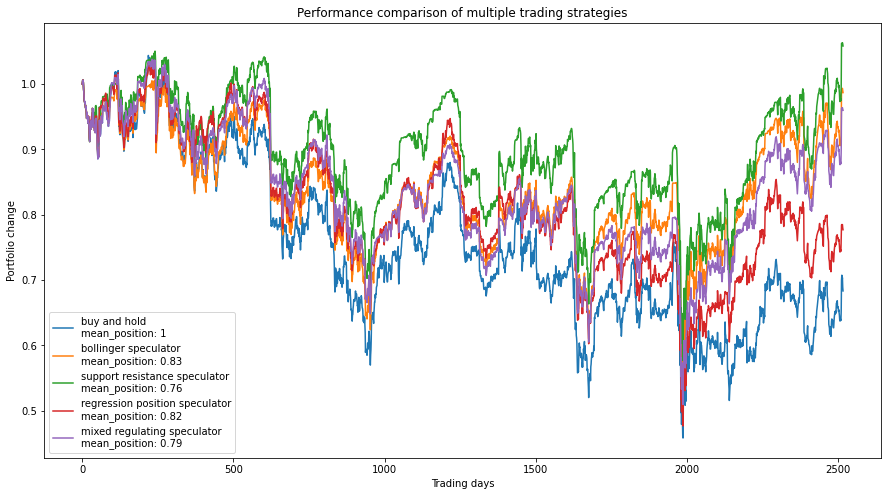

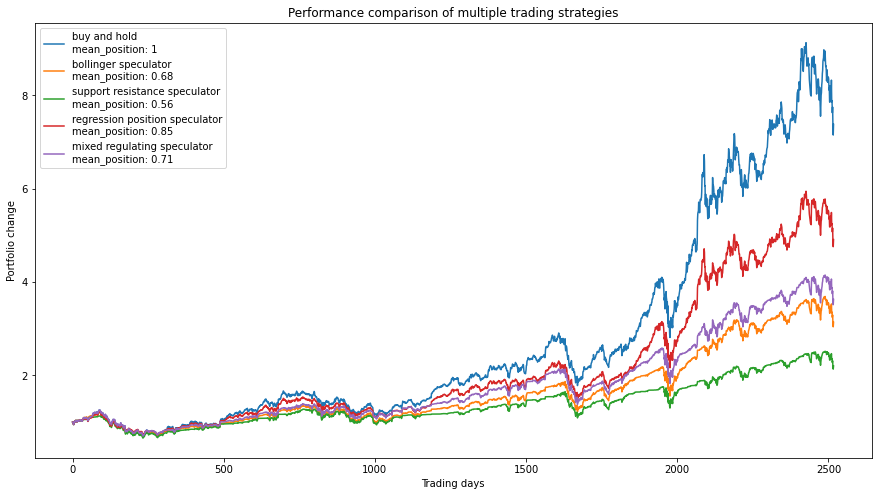

In [147]:
compare_strategies(value_stock, regulating_speculator_strategies)
compare_strategies(growth_stock, regulating_speculator_strategies)

In [148]:
# define the trend follower strategy
def trend_follower(stock, trend):
    return np.clip(np.where(np.isnan(stock[trend]), 1, stock[trend]), 0, 1)

In [149]:
trend_follower_strategies = {
    "ma trend 20-50" : lambda stock: trend_follower(stock, "ma_trend20_50"),
    #"ma trend 50-100" : lambda stock: trend_follower(stock, "ma_trend50_100"),
    "ma trend 50-200" : lambda stock: trend_follower(stock, "ma_trend50_200")
}

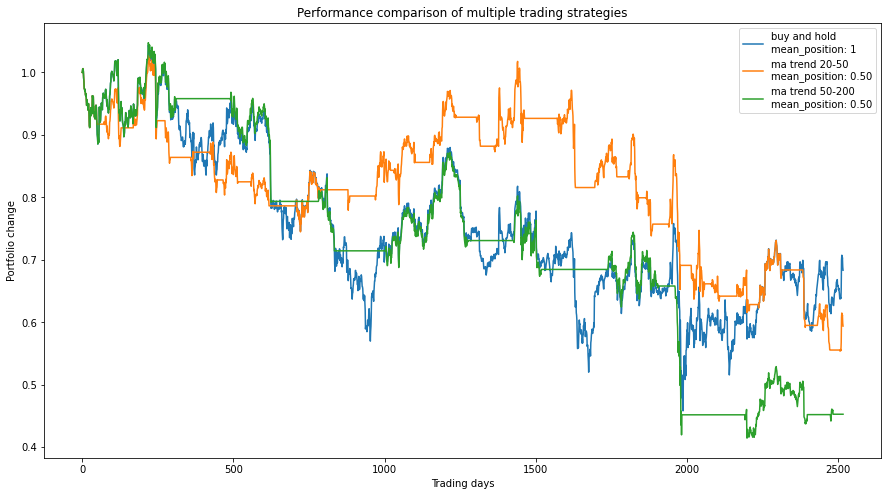

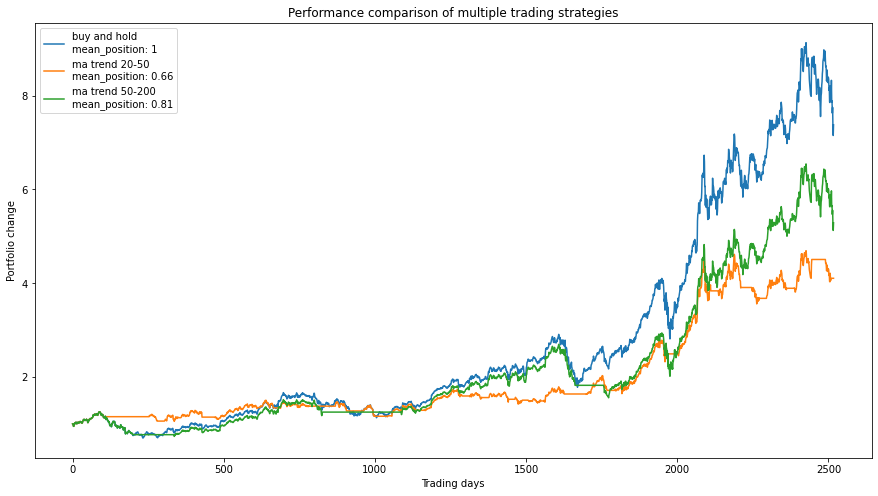

In [150]:
compare_strategies(value_stock, trend_follower_strategies)
compare_strategies(growth_stock, trend_follower_strategies)

In [151]:
def moving_average_balancer(stock, ma):
    #return np.clip(np.where(np.isnan(stock[ma]), 1, 500 * stock[ma]),0, 1)
    return np.where(stock[ma] > 0, 1, 0)

In [131]:
ema_strategies = {
    "ema10 balancer": lambda stock: moving_average_balancer(stock, "ema10"),
    "ema20 balancer": lambda stock: moving_average_balancer(stock, "ema20"),
    "ema50 balancer": lambda stock: moving_average_balancer(stock, "ema50"),
    "ema100 balancer": lambda stock: moving_average_balancer(stock, "ema100"),
    "ema200 balancer": lambda stock: moving_average_balancer(stock, "ema200")
}

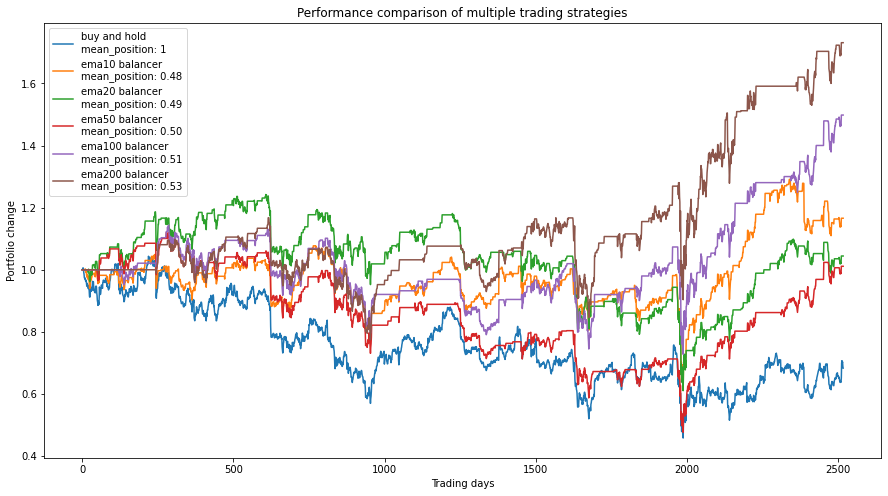

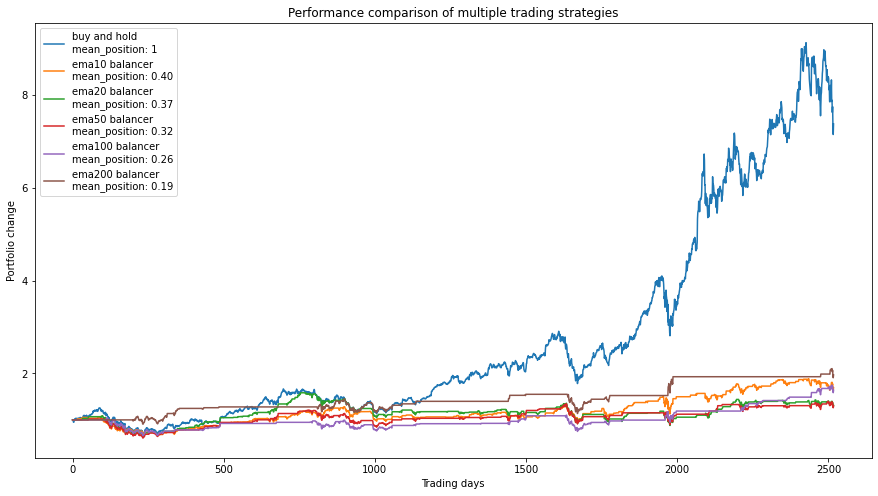

In [132]:
compare_strategies(value_stock, ema_strategies)
compare_strategies(growth_stock, ema_strategies)